In [75]:
import numpy as np
import pandas as pd
import datetime
from sklearn import preprocessing
from datetime import datetime
from sklearn.svm import SVC
import operator
import googlefinance.client as gfc
from matplotlib import pyplot as plt
%matplotlib notebook

The goal of this notebook is to create time series regression models using some regression models as well as "Forest" models (both regression and deep learning versions). 

The features for this part of the research are going to be extracted using data freely available in Python via Quandl and pandas Yahoo finance support. 

- NASDAQ Composite
- Dow Jones Industrial Average
- Frankfurt DAX
- London FTSE-100
- Paris CAC 40
- Tokyo Nikkei-225
- Hong Kong Hang Seng
- Australia ASX-200

The features will be extracted from the major market indicators above will have the following format:

- Date : in days

- Open : price of the stock at the opening of the trading (in US dollars)
- High : highest price of the stock during the day (in US dollars)
- Low : lowest price of the stock during the trading day (in US dollars)
- Close : price of the stock at the closing of the trading (in US dollars)
- Volume : amount of stocks traded (in US dollars)
- Adj Close : price of the stock at the closing of the trading adjusted with dividends (in US dollars)

In [112]:
params = [
    {'q': "IXIC",
     'x': 'INDEXNASDAQ'
    },
    {'q': '.DJI',
      'x': 'INDEXDJX'  
    },
    {'q':'DAX',
     'x':'INDEXDB'   
    },
    {'q': 'UKX',
      'x':'INDEXFTSE'   
    },
    {'q': 'PX1',
      'x': 'INDEXEURO'   
    },
    {'q': 'NI225',
      'x': 'INDEXNIKKEI'  
    },
    {'q': 'HSI',
      'x': 'INDEXHANGSENG'  
    },
    {'q': 'XJO',
      'x':'INDEXASX'   
    }
]
period = "6M"
# get closing price data (return pandas dataframe)
df = gfc.get_closing_data(params, period)
df.head()

,IXIC,.DJI,DAX,UKX,PX1,NI225,HSI,XJO
2017-02-28,5825.437553,20812.24,NaN,NaN,NaN,19118.99,23740.73,5712.2
2017-03-01,5904.029346,21115.55,12067.19,7382.90,4960.83,19393.54,23776.49,5704.8
2017-03-02,5861.221817,21002.97,12059.57,7382.35,4963.80,19564.80,23728.07,5776.6
2017-03-03,5870.753072,21005.71,12027.36,7374.26,4995.13,19469.17,23552.72,5729.6
2017-03-06,5849.174826,20954.34,11958.40,7350.12,4972.19,19379.14,23596.28,5746.5


In [113]:
# Log Days Returns: log of Adjusted Close Price of i-th day  compared to (i-1)-th day. 
log_returns = np.log(df) - np.log(df.shift(1))

In [114]:
# Percentage diff of adjusted cose price to 3 days ago
three_day_pct = df.pct_change(3)

In [115]:
three_day_pct.tail()

,IXIC,.DJI,DAX,UKX,PX1,NI225,HSI,XJO
2017-08-23,0.009954,0.006348,0.000749,0.008011,0.000242,-0.001837,NaN,-0.001723
2017-08-24,0.009367,0.003670,0.009518,0.012048,0.005020,-0.002030,0.013402,0.003423
2017-08-25,-0.005055,-0.003937,-0.005021,0.002671,-0.005365,0.003548,0.016294,-0.001078
2017-08-28,0.000734,-0.000169,-0.004175,NaN,-0.006967,0.000785,0.016846,-0.004758
2017-08-29,NaN,NaN,-0.019289,-0.009400,-0.015883,0.000454,0.008954,-0.013315


In [116]:
log_returns.head()

,IXIC,.DJI,DAX,UKX,PX1,NI225,HSI,XJO
2017-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-03-01,0.013401,0.014468,NaN,NaN,NaN,0.014258,0.001505,-0.001296
2017-03-02,-0.007277,-0.005346,-0.000632,-0.000074,0.000599,0.008792,-0.002039,0.012507
2017-03-03,0.001625,0.000130,-0.002674,-0.001096,0.006292,-0.004900,-0.007417,-0.008170
2017-03-06,-0.003682,-0.002449,-0.005750,-0.003279,-0.004603,-0.004635,0.001848,0.002945


In [117]:
df.corr(method='spearman')

,IXIC,.DJI,DAX,UKX,PX1,NI225,HSI,XJO
IXIC,1.000000,0.884386,0.384266,0.583268,0.401744,0.706009,0.921142,-0.420645
.DJI,0.884386,1.000000,0.180347,0.432421,0.181432,0.678526,0.891275,-0.486821
DAX,0.384266,0.180347,1.000000,0.490087,0.919010,0.579929,0.260659,0.018782
UKX,0.583268,0.432421,0.490087,1.000000,0.465313,0.601123,0.511432,-0.335156
PX1,0.401744,0.181432,0.919010,0.465313,1.000000,0.502852,0.296140,0.070111
NI225,0.706009,0.678526,0.579929,0.601123,0.502852,1.000000,0.602001,-0.417725
HSI,0.921142,0.891275,0.260659,0.511432,0.296140,0.602001,1.000000,-0.434798
XJO,-0.420645,-0.486821,0.018782,-0.335156,0.070111,-0.417725,-0.434798,1.000000


In [118]:
df.corr(method='kendall')

,IXIC,.DJI,DAX,UKX,PX1,NI225,HSI,XJO
IXIC,1.000000,0.686289,0.277622,0.385738,0.239182,0.493388,0.749311,-0.277956
.DJI,0.686289,1.000000,0.096095,0.278041,0.033569,0.502479,0.709917,-0.313898
DAX,0.277622,0.096095,1.000000,0.333224,0.750603,0.394398,0.166509,0.009838
UKX,0.385738,0.278041,0.333224,1.000000,0.347764,0.422192,0.333770,-0.213467
PX1,0.239182,0.033569,0.750603,0.347764,1.000000,0.319559,0.134746,0.046596
NI225,0.493388,0.502479,0.394398,0.422192,0.319559,1.000000,0.412619,-0.266896
HSI,0.749311,0.709917,0.166509,0.333770,0.134746,0.412619,1.000000,-0.282984
XJO,-0.277956,-0.313898,0.009838,-0.213467,0.046596,-0.266896,-0.282984,1.000000


<IPython.core.display.Javascript object>


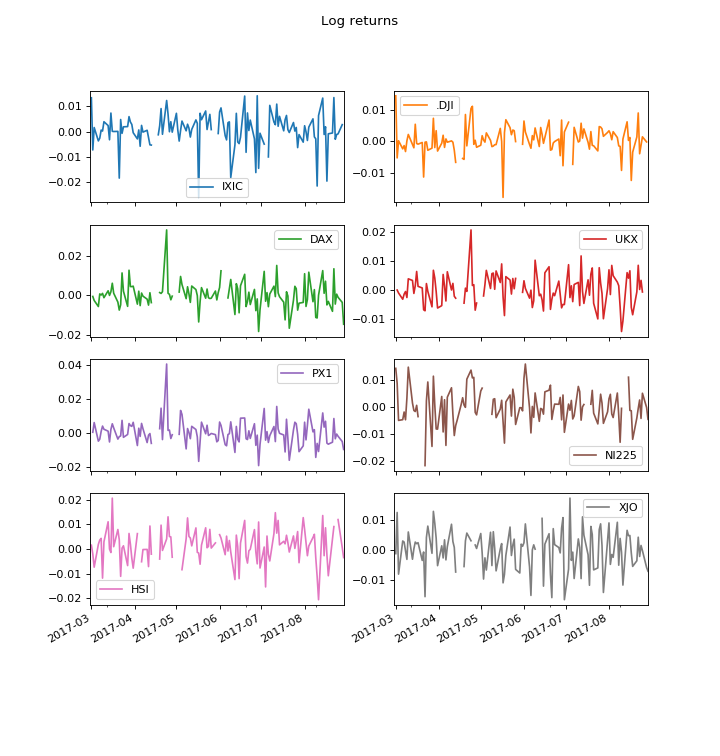

In [119]:
log_returns.plot(subplots=True, layout=(4, 2), figsize=(8, 8), sharex=True, title='Log returns');